In [1]:
import pandas as pd

df = pd.read_csv("english_hindi_dataset.csv", encoding="utf-8")
print(df.head())


  English    Hindi
0   Help!    बचाओ!
1   Jump.    उछलो.
2   Jump.    कूदो.
3   Jump.   छलांग.
4  Hello!  नमस्ते।


In [2]:
print("Dataset preview:\n", df.head())
print("\nColumns:", df.columns)
print("Total samples:", len(df))

Dataset preview:
   English    Hindi
0   Help!    बचाओ!
1   Jump.    उछलो.
2   Jump.    कूदो.
3   Jump.   छलांग.
4  Hello!  नमस्ते।

Columns: Index(['English', 'Hindi'], dtype='object')
Total samples: 130476


In [3]:
# 1. Remove duplicates
df = df.drop_duplicates()
print("After removing duplicates:", len(df))

After removing duplicates: 127688


In [4]:
# 2. Drop missing values
df = df.dropna()
print("After removing nulls:", len(df))

After removing nulls: 127375


In [5]:
# 3. Strip whitespaces
df["English"] = df["English"].str.strip()
df["Hindi"] = df["Hindi"].str.strip()

In [6]:
# Count English sentences with only 1 word
english_single_word = df[df["English"].str.split().str.len() == 1]

# Count Hindi sentences with only 1 word
hindi_single_word = df[df["Hindi"].str.split().str.len() == 1]

In [7]:
print("English single-word rows:", len(english_single_word))
print("Hindi single-word rows:", len(hindi_single_word))


English single-word rows: 1570
Hindi single-word rows: 1953


In [8]:
# 5. Reset index
df = df.reset_index(drop=True)

In [9]:
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print("\nSplit sizes:")
print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))


Split sizes:
Train: 101900
Validation: 12737
Test: 12738


In [10]:
from transformers import MarianMTModel, MarianTokenizer
import torch
import pandas as pd


In [49]:
# MarianMT model for English to Hindi
marian_model_name = "Helsinki-NLP/opus-mt-en-hi"
marian_tokenizer = MarianTokenizer.from_pretrained(marian_model_name)
marian_model = MarianMTModel.from_pretrained(marian_model_name)

In [50]:
def translate(sentences, max_length=128):
    translations = []
    for sentence in sentences:
        batch = marian_tokenizer([sentence], return_tensors="pt", max_length=max_length, truncation=True)
        translated = marian_model.generate(**batch)
        tgt_text = [marian_tokenizer.decode(t, skip_special_tokens=True) for t in translated]
        translations.append(tgt_text[0])
    return translations


In [13]:
# Example: first 5 English sentences from test set
sample_sentences = test_df['English'].tolist()[:5]

translated_sentences = translate(sample_sentences)

for en, hi in zip(sample_sentences, translated_sentences):
    print(f"English: {en}")
    print(f"Predicted Hindi: {hi}")
    print("-"*50)


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4129: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


English: How about going to the movies?
Predicted Hindi: फिल्म देखने के बारे में क्या?
--------------------------------------------------
English: And again, everything is autonomous,
Predicted Hindi: और फिर, सब कुछ एक संग्रह है.
--------------------------------------------------
English: so that when the unsuspecting insect
Predicted Hindi: ताकि तुम लोग तराज़ू (से तौलने) में हद से तजाउज़ न करो
--------------------------------------------------
English: Related video are fixed by tag or title, In second year of YouTube they given the rights to publish the videos, to increase the working capacity they added functions like videos feedback, membership, and additional information fields.
Predicted Hindi: संबंधित वीडियो टैग या शीर्षक द्वारा स्थिर हैं, यूट्यूब के दूसरे वर्ष में उन्होंने वीडियो प्रकाशित करने के लिए अधिकार दिए हैं, जो कि वीडियो फ़ीडबैक, सदस्यता तथा अतिरिक्‍त जानकारी क्षेत्रों की तरह काम करता है ।
--------------------------------------------------
English: Do you believe me?
Pr

In [14]:
from nltk.translate.bleu_score import sentence_bleu

for ref, pred in zip(test_df['Hindi'].tolist()[:5], translated_sentences):
    reference = [ref.split()]
    candidate = pred.split()
    score = sentence_bleu(reference, candidate)
    print(f"Reference: {ref}")
    print(f"Predicted: {pred}")
    print(f"BLEU score: {score}")
    print("-"*50)


Reference: फ़िल्म देखने चलें क्या?
Predicted: फिल्म देखने के बारे में क्या?
BLEU score: 1.384292958842266e-231
--------------------------------------------------
Reference: और फिर, सब कुछ स्वायत्त है,
Predicted: और फिर, सब कुछ एक संग्रह है.
BLEU score: 0.41113361690051975
--------------------------------------------------
Reference: ताकि जब अनजान कीड़े
Predicted: ताकि तुम लोग तराज़ू (से तौलने) में हद से तजाउज़ न करो
BLEU score: 9.788429383461836e-232
--------------------------------------------------
Reference: संबंधित वीडियो शीर्षक और टैग (tags)द्वारा निर्धारित है प्रकट करने के लिए परदे के अधिकार का एक वीडियो दिया यूट्यूब के दूसरे वर्ष में उपयॊगकर्ता की कार्य क्षमता बढ़ाने के लिए वीडियो प्रतिक्रिया पॊस्ट करने और सदस्यता लेने के लिए फ़ीड सामग्री के लिए फ़क्शन बढ़ाए गए हैं
Predicted: संबंधित वीडियो टैग या शीर्षक द्वारा स्थिर हैं, यूट्यूब के दूसरे वर्ष में उन्होंने वीडियो प्रकाशित करने के लिए अधिकार दिए हैं, जो कि वीडियो फ़ीडबैक, सदस्यता तथा अतिरिक्‍त जानकारी क्षेत्रों की तरह काम करता है

/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [15]:
from nltk.translate.bleu_score import sentence_bleu

bleu_scores = []

for ref, pred in zip(test_df['Hindi'].tolist(), translated_sentences):
    reference = [ref.split()]
    candidate = pred.split()
    score = sentence_bleu(reference, candidate)
    bleu_scores.append(score)

print("Average BLEU score:", sum(bleu_scores)/len(bleu_scores))


Average BLEU score: 0.10581888617948203


In [16]:
# Single sentence
english_sentence = "I am learning Natural Language Processing."

predicted_hindi = translate([english_sentence])[0]  # pass as a list
print(f"English: {english_sentence}")
print(f"Predicted Hindi: {predicted_hindi}")


English: I am learning Natural Language Processing.
Predicted Hindi: मैं कुदरती भाषा सीख रहा हूँ ।


In [17]:
def evaluate_translation(df, dataset_name="Test", batch_size=32):
    import pandas as pd
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.translate.meteor_score import single_meteor_score
    from nltk.tokenize import word_tokenize
    from rouge_score import rouge_scorer

    print(f"\nEvaluating {dataset_name} set...")

    english_sentences = df['English'].tolist()
    reference_sentences = df['Hindi'].tolist()

    # Translate in batches
    predicted_sentences = []
    for i in range(0, len(english_sentences), batch_size):
        batch = english_sentences[i:i+batch_size]
        predicted_batch = translate(batch)
        predicted_sentences.extend(predicted_batch)
        print(f"Translated {i+len(batch)}/{len(english_sentences)} sentences...")

    # Initialize score lists
    bleu_scores = []
    meteor_scores = []
    rouge_scores = []
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    # Compute scores
    for ref, pred in zip(reference_sentences, predicted_sentences):
        # BLEU
        reference = [ref.split()]
        candidate = pred.split()
        bleu_scores.append(sentence_bleu(reference, candidate))

        # METEOR - tokenized
        ref_tokens = word_tokenize(ref)
        pred_tokens = word_tokenize(pred)
        meteor_scores.append(single_meteor_score(ref_tokens, pred_tokens))

        # ROUGE-L
        rouge_scores.append(scorer.score(ref, pred)['rougeL'].fmeasure)

    # Print average scores
    print(f"\n{dataset_name} Average BLEU: {sum(bleu_scores)/len(bleu_scores):.4f}")
    print(f"{dataset_name} Average METEOR: {sum(meteor_scores)/len(meteor_scores):.4f}")
    print(f"{dataset_name} Average ROUGE-L: {sum(rouge_scores)/len(rouge_scores):.4f}")

    # Show first 5 examples
    print("\nSample Predictions:")
    for en, ref, pred in zip(english_sentences[:5], reference_sentences[:5], predicted_sentences[:5]):
        print(f"English: {en}")
        print(f"Reference Hindi: {ref}")
        print(f"Predicted Hindi: {pred}")
        print("-"*50)

In [19]:
import nltk
nltk.download('punkt')  # Download tokenizer data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=31976a9bdbceabd567e3c0ee74f40f7c351ca5cbb25afe0e9c81957b182533e0
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [26]:
# Take first 200 sentences for faster evaluation
val_small = val_df.head(100)
test_small = test_df.head(100)

# Evaluate
evaluate_translation(val_small, dataset_name="Validation-Small", batch_size=32)
evaluate_translation(test_small, dataset_name="Test-Small", batch_size=32)



Evaluating Validation-Small set...


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4129: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Translated 32/100 sentences...
Translated 64/100 sentences...
Translated 96/100 sentences...
Translated 100/100 sentences...


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Validation-Small Average BLEU: 0.0485
Validation-Small Average METEOR: 0.2740
Validation-Small Average ROUGE-L: 0.0467

Sample Predictions:
English: It is for this reason, that many characters in Indian literature as well as cinema, were based on Akbar.
Reference Hindi: इसलिए भारतीय साहित्य एवं सिनेमा ने अकबर से प्रेरित कई पात्र रचे गए हैं।
Predicted Hindi: इस कारण, भारत के साहित्य में और साथ ही सिनेमा - घरों में अनेक अक्षर एकबार पर आधारित थे ।
--------------------------------------------------
English: Considering the ways of spreading Krishna's teachings of sri vallanhacharya he wrote poetry of krishna Bhakti.
Reference Hindi: श्री वल्लभाचार्य द्वारा प्रचारित पुष्टिमार्ग में दीक्षित होकर सूरदास आदि अष्टछाप के कवियोंने कृष्ण-भक्ति-साहित्य की रचना की।
Predicted Hindi: तथाकथित वर्मा की शिक्षाओं को फैलाने के तरीके पर विचार करते हुए उसने खिशना बॉइटी की कविता लिखी।
--------------------------------------------------
English: Which is, I think, why we're particularly drawn to nature.
Refere

In [ ]:
# Interactive English → Hindi translation demo
while True:
    sentence = input("Enter an English sentence (or type 'exit' to quit):\n")
    if sentence.lower() == "exit":
        print("Exiting translation demo.")
        break

    # Translate the sentence
    translation = translate([sentence])[0]  # translate() returns a list
    print(f"Predicted Hindi: {translation}\n")


Enter an English sentence (or type 'exit' to quit):
what ur doing?
Predicted Hindi: क्या कर रहे हो?

Enter an English sentence (or type 'exit' to quit):
how can i help u
Predicted Hindi: कैसे मैं uu की मदद कर सकते हैं

Enter an English sentence (or type 'exit' to quit):
how can i help you
Predicted Hindi: कैसे मैं आपकी मदद कर सकते हैं

Enter an English sentence (or type 'exit' to quit):
exit
Exiting translation demo.


In [28]:
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer, AutoModelForSeq2SeqLM, AutoTokenizer
m2m_name = "facebook/m2m100_418M"
m2m_tokenizer = M2M100Tokenizer.from_pretrained(m2m_name)
m2m_model = M2M100ForConditionalGeneration.from_pretrained(m2m_name)

tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

In [29]:
def translate_m2m(sentences, max_length=128):
    translations = []
    for sentence in sentences:
        batch = m2m_tokenizer(sentence, return_tensors="pt", max_length=max_length, truncation=True)
        generated = m2m_model.generate(**batch, forced_bos_token_id=m2m_tokenizer.get_lang_id("hi"))
        tgt_text = m2m_tokenizer.batch_decode(generated, skip_special_tokens=True)
        translations.append(tgt_text[0])
    return translations

In [36]:
model_name = "facebook/nllb-200-distilled-600M"
tokenizer_nllb = AutoTokenizer.from_pretrained(model_name)
model_nllb = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [37]:
def translate_nllb(sentences, src_lang="eng_Latn", tgt_lang="hin_Deva"):
    inputs = tokenizer_nllb(sentences, return_tensors="pt", padding=True, truncation=True).to(model_nllb.device)

    # Force the decoder to start with target language token
    generated_tokens = model_nllb.generate(
        **inputs,
        forced_bos_token_id=tokenizer_nllb.convert_tokens_to_ids(tgt_lang),
        max_length=128
    )

    return tokenizer_nllb.batch_decode(generated_tokens, skip_special_tokens=True)

In [42]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer
from tqdm import tqdm
from nltk.tokenize import word_tokenize

# ✅ Universal evaluation function
def evaluate_all_models(df, models, sample_size=200, batch_size=32):
    """
    Compare multiple translation models on BLEU, METEOR, ROUGE-L.
    df: DataFrame with 'English' and 'Hindi' columns
    models: dict { "ModelName": translate_function }
    sample_size: number of samples to evaluate
    """
    results = []

    # Subsample for faster evaluation
    df_sample = df.head(sample_size)

    english_sentences = df_sample['English'].tolist()
    reference_sentences = df_sample['Hindi'].tolist()

    for model_name, translate_func in models.items():
        print(f"\n🔎 Evaluating {model_name}...")
        predicted_sentences = []

        # Batch translation
        for i in tqdm(range(0, len(english_sentences), batch_size)):
            batch = english_sentences[i:i+batch_size]
            preds = translate_func(batch)
            predicted_sentences.extend(preds)

        # Metrics
        bleu_scores, meteor_scores, rouge_scores = [], [], []
        scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

        for ref, pred in zip(reference_sentences, predicted_sentences):
            ref_tokens = ref.split()
            pred_tokens = pred.split() # Tokenize predicted sentence

            # BLEU
            bleu_scores.append(sentence_bleu([ref_tokens], pred_tokens))

            # METEOR
            meteor_scores.append(single_meteor_score(ref_tokens, pred_tokens)) # Pass tokenized sentences

            # ROUGE-L
            rouge_scores.append(scorer.score(ref, pred)['rougeL'].fmeasure)

        results.append({
            "Model": model_name,
            "BLEU": sum(bleu_scores)/len(bleu_scores),
            "METEOR": sum(meteor_scores)/len(meteor_scores),
            "ROUGE-L": sum(rouge_scores)/len(rouge_scores),
        })

    # 📊 Create comparison table
    results_df = pd.DataFrame(results)
    print("\n✅ Final Comparison Table:")
    print(results_df)
    return results_df

In [43]:
# Dictionary of models
models = {
    "MarianMT (Helsinki)": translate,         # your MarianMT function
    "M2M100 (Facebook)": translate_m2m,       # your M2M100 function
    "NLLB-200 (Meta)": translate_nllb         # your fixed NLLB function
}

# Run comparison
comparison_df = evaluate_all_models(test_df, models, sample_size=100)


🔎 Evaluating MarianMT (Helsinki)...


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4129: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
100%|██████████| 4/4 [01:51<00:00, 27.78s/it]
/usr/local/lib/python3.12/dist-packages/nltk/


🔎 Evaluating M2M100 (Facebook)...


100%|██████████| 4/4 [15:25<00:00, 231.46s/it]



🔎 Evaluating NLLB-200 (Meta)...


100%|██████████| 4/4 [04:40<00:00, 70.03s/it]


✅ Final Comparison Table:
                 Model      BLEU    METEOR   ROUGE-L
0  MarianMT (Helsinki)  0.033611  0.228720  0.033333
1    M2M100 (Facebook)  0.070092  0.262795  0.057500
2      NLLB-200 (Meta)  0.094670  0.358970  0.074881


In [44]:
# Function to translate a single sentence with all three models
def translate_sentence_all_models(sentence):
    """
    Input: English sentence (string)
    Output: Dictionary with predicted Hindi translations from three models
    """
    translations = {}

    # MarianMT
    translations["MarianMT (Helsinki)"] = translate([sentence])[0]

    # M2M100
    translations["M2M100 (Facebook)"] = translate_m2m([sentence])[0]

    # NLLB-200
    translations["NLLB-200 (Meta)"] = translate_nllb([sentence])[0]

    return translations

# Example usage
english_input = "How are you doing today?"
predicted_translations = translate_sentence_all_models(english_input)

# Print results neatly
print(f"English: {english_input}\n")
for model, translation in predicted_translations.items():
    print(f"{model}: {translation}")


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4129: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


English: How are you doing today?

MarianMT (Helsinki): आज आप कैसे कर रहे हैं?
M2M100 (Facebook): आज आप कैसे कर रहे हैं?
NLLB-200 (Meta): आज आप कैसे हैं?


In [51]:
# Interactive translation loop
print("English → Hindi Translation (MarianMT, M2M100, NLLB-200)")
print("Type 'exit' to quit.\n")

while True:
    # Take runtime input
    english_input = input("Enter English sentence: ")

    if english_input.lower() == "exit":
        print("Exiting...")
        break

    # Generate translations
    predicted_translations = translate_sentence_all_models(english_input)

    # Print results
    print(f"\nEnglish: {english_input}\n")
    for model, translation in predicted_translations.items():
        print(f"{model}: {translation}")
    print("\n" + "-"*50 + "\n")


English → Hindi Translation (MarianMT, M2M100, NLLB-200)
Type 'exit' to quit.

Enter English sentence: is there class today?

English: is there class today?

MarianMT (Helsinki): आज वहाँ वर्ग है?
M2M100 (Facebook): आज क्लास है?
NLLB-200 (Meta): क्या आज कोई क्लास है?

--------------------------------------------------

Enter English sentence: how are you

English: how are you

MarianMT (Helsinki): आप कैसे हैं
M2M100 (Facebook): आप कैसे हैं
NLLB-200 (Meta): आप कैसे हैं

--------------------------------------------------

Enter English sentence: what about the today day

English: what about the today day

MarianMT (Helsinki): आज के दिन के बारे में क्या?
M2M100 (Facebook): आज के दिन के बारे में क्या
NLLB-200 (Meta): आज के दिन के बारे में क्या

--------------------------------------------------

Enter English sentence: good luck

English: good luck

MarianMT (Helsinki): गुड लक
M2M100 (Facebook): अच्छा भाग्य
NLLB-200 (Meta): शुभकामनाएँ

--------------------------------------------------

Ent

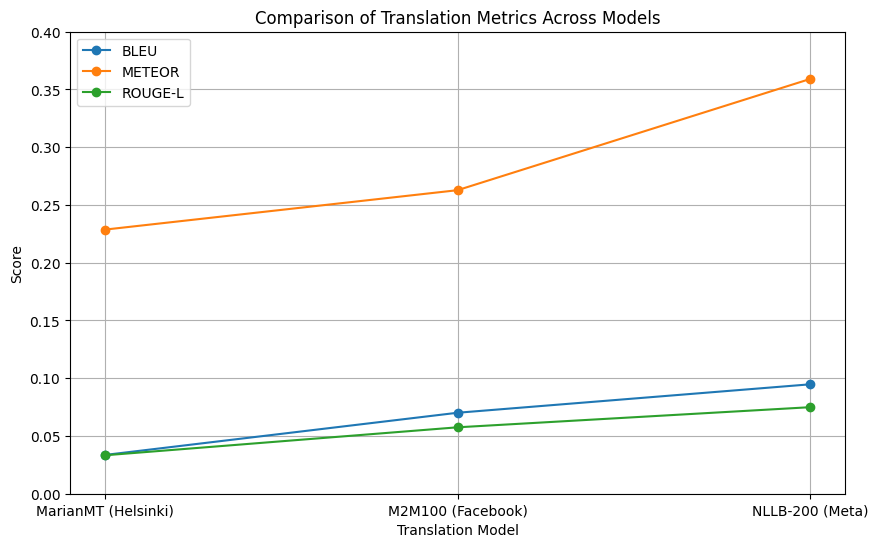

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# Example scores from your evaluation (replace with your actual values)
data = {
    "Model": ["MarianMT (Helsinki)", "M2M100 (Facebook)", "NLLB-200 (Meta)"],
    "BLEU": [0.0336, 0.0701, 0.0947],
    "METEOR": [0.2287, 0.2628, 0.3590],
    "ROUGE-L": [0.0333, 0.0575, 0.0749]
}

df_scores = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(df_scores["Model"], df_scores["BLEU"], marker='o', label="BLEU")
plt.plot(df_scores["Model"], df_scores["METEOR"], marker='o', label="METEOR")
plt.plot(df_scores["Model"], df_scores["ROUGE-L"], marker='o', label="ROUGE-L")

plt.title("Comparison of Translation Metrics Across Models")
plt.xlabel("Translation Model")
plt.ylabel("Score")
plt.ylim(0, 0.4)  # Adjust based on your scores
plt.grid(True)
plt.legend()
plt.show()
